#### [Tugas Metstat Mana] - Maxwell Thomson
### Import Library

In [ ]:
!pip install s2cell
import s2cell
from datetime import datetime
import pytz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans 
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data pre-processing

In [ ]:
def s2_kota(a):
    lat = s2cell.cell_id_to_lat_lon(s2cell.token_to_cell_id('{}'.format(a)))[0]
    long = s2cell.cell_id_to_lat_lon(s2cell.token_to_cell_id('{}'.format(a)))[1]
    return pd.Series([lat,long],index=['lat','long'])

#### Train-Test

In [ ]:
url = 'https://raw.githubusercontent.com/maxwelth/irregularities-phenomenon-dsw/main/data/data_train.csv'
url2 = 'https://raw.githubusercontent.com/maxwelth/irregularities-phenomenon-dsw/main/data/data_test.csv'
df1 = pd.read_csv(url)
df2 = pd.read_csv(url2)


def pre_step(x):
    x[['s2','date','hour']] = x.Ids.str.split('_',2).tolist()
    x.drop(columns=['Ids'],inplace=True)
    x['date'] = x['date'].astype('datetime64[ns]')
    x['day_week'] = x['date'].dt.dayofweek
    x['day_week_name'] = x['date'].dt.day_name()
    x['is_weekend'] = np.where(x['day_week_name'].isin(['Sunday','Saturday']), 1, 0)
    x = x.drop(columns=['day_week_name'])
    x[['lat','long']] = x['s2'].apply(lambda x : s2_kota(x))
    return x

df1 = pre_step(df1)
df2 = pre_step(df2)

le = LabelEncoder()
df['Labels'] = le.fit_transform(df['Labels'])
df2 = df2.drop(columns=['date'])
df1 = df1.drop(columns=['day_week'])

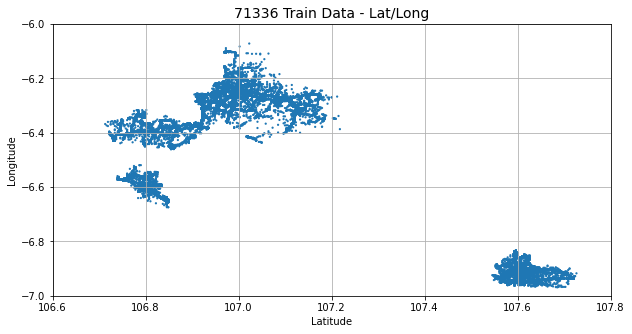

In [ ]:
fig = plt.figure(figsize=(10,5))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(df1['long'], df1['lat'],
            cmap=cmap, norm=norm, s=5, edgecolor='none')
plt.xlim(106.6, 107.8)
plt.ylim(-7, -6)
plt.xlabel('Latitude', fontsize=10)
plt.ylabel('Longitude', fontsize=10)
plt.title('71336 Train Data - Lat/Long', fontsize=14)
plt.grid()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df1[['lat','long']].values)
predictions = kmeans.predict(df1[['lat','long']].values)
clustered = pd.concat([df1.reset_index(), pd.DataFrame({'Cluster':predictions})], axis=1)
clustered_first = clustered.drop(columns=['index','s2','date','lat','long'])

predictions1 = kmeans.predict(df2[['lat','long']].values)
clustered2 = pd.concat([df2.reset_index(), pd.DataFrame({'Cluster':predictions1})], axis=1)
clustered2_first = clustered2.drop(columns=['index','s2','day_week','lat','long'])

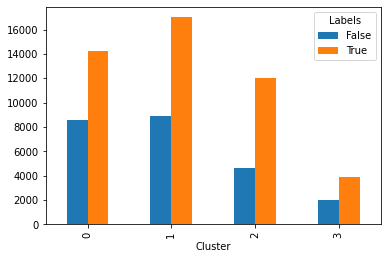

In [ ]:
pd.crosstab(clustered_first['Cluster'],clustered_first['Labels']).plot.bar()

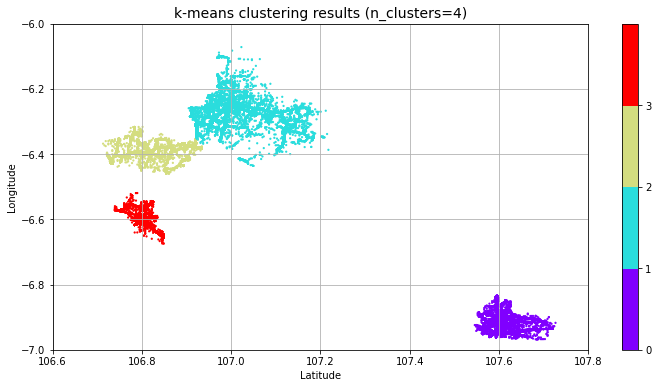

In [ ]:
fig = plt.figure(figsize=(12,6))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,5,1), cmap.N)
plt.scatter(clustered['long'], clustered['lat'], c=clustered['Cluster'],
            cmap=cmap, norm=norm, s=5, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,3,4))
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3);
plt.xlim(106.6, 107.8)
plt.ylim(-7, -6)
plt.xlabel('Latitude', fontsize=10)
plt.ylabel('Longitude', fontsize=10)
plt.title('k-means clustering results (n_clusters=4)', fontsize=14)
plt.grid()
plt.show()

#### Alerts

In [ ]:
#use_cols = ['pub_millis','s2token_15','road_type','city','magvar','reliability','report_rating','confidence', 'type']
#alerts =pd.read_csv('alerts.csv', usecols=use_cols)
#alerts = alerts.drop_duplicates()
#alerts.to_csv('alerts_clean.csv',index=False)

alerts = pd.read_csv('https://raw.githubusercontent.com/maxwelth/irregularities-phenomenon-dsw/main/data/alerts_clean.csv')
alerts['waktu']=alerts['pub_millis'].apply(lambda x: datetime.utcfromtimestamp(int(x)/1000).astimezone(pytz.timezone("Asia/Bangkok")).strftime('%Y-%m-%d_%H'))
alerts = alerts.drop(columns=['pub_millis'])
alerts[['date','hour']] = alerts.waktu.str.split('_',1).tolist()
alerts['date'] = alerts['date'].astype('datetime64[ns]')
alerts['day_week'] = alerts['date'].dt.dayofweek
alerts = alerts.drop_duplicates()

alertss = alerts.copy()    #train
alertsst = alerts.copy()   #test

### Split into two data sets

#### a) Train

In [ ]:
clustered['lookup1'] = clustered['s2'] + clustered['date'].astype(str) + "_" + clustered['hour'].astype(str)
alertss['lookup1'] =  alertss['s2token_15'] + alertss['date'].astype(str) + "_" + alertss['hour'].astype(str)

In [ ]:
data_trainn_yes1=clustered.loc[clustered['lookup1'].isin(alertss['lookup1'])]
data_trainn_non1=clustered.loc[~clustered.index.isin(data_trainn_yes1.index)]

In [ ]:
alertsf = alertss.drop_duplicates(subset=['lookup1'])
s1 = pd.merge(data_trainn_yes1, alertsf, how='inner', on=['lookup1'])
s1 = s1.drop(columns=['s2','s2token_15','date_x','hour_x','lookup1','waktu','day_week','date_y','city'])
s1 = s1.set_index(data_trainn_yes1.index)   #s1 = data_trainn_yes1

#### b) Test

In [ ]:
clustered2['lookup1'] = clustered2['s2']  + "_" + clustered2['hour'].astype(str) + "_" + clustered2['day_week'].astype(str)
alertsst['lookup1'] = alertsst['s2token_15'] + "_" + alertsst['hour'].astype(str) + "_" + alertsst['day_week'].astype(str)

In [ ]:
data_testt_yes1=clustered2.loc[clustered2['lookup1'].isin(alertsst['lookup1'])]
data_testt_non1=clustered2.loc[~clustered2.index.isin(data_testt_yes1.index)]

In [ ]:
alertsft = alertsst.drop_duplicates(subset=['lookup1'])
s2 = pd.merge(data_testt_yes1, alertsft, how='inner', on=['lookup1'])
s2 = s2.drop(columns=['s2','s2token_15','hour_x','day_week_x','lookup1','city','waktu','day_week_y','date'])
s2 = s2.set_index(data_testt_yes1.index) 

#### label viz

In [ ]:
awo_list = [[s1.shape[0],s2.shape[0]], [data_trainn_non1.shape[0],data_testt_non1.shape[0]],[clustered.shape[0],data_testt_non1.shape[0]]]
awo_df = pd.DataFrame(awo_list, columns=['train size', 'test size'])
awo_df['label']= pd.DataFrame(['Train + Alerts','Train only - 1','Train only - 2(after)'])
awo_df = awo_df.reindex(columns=['label','train size','test size'])
awo_df = awo_df.set_index('label')

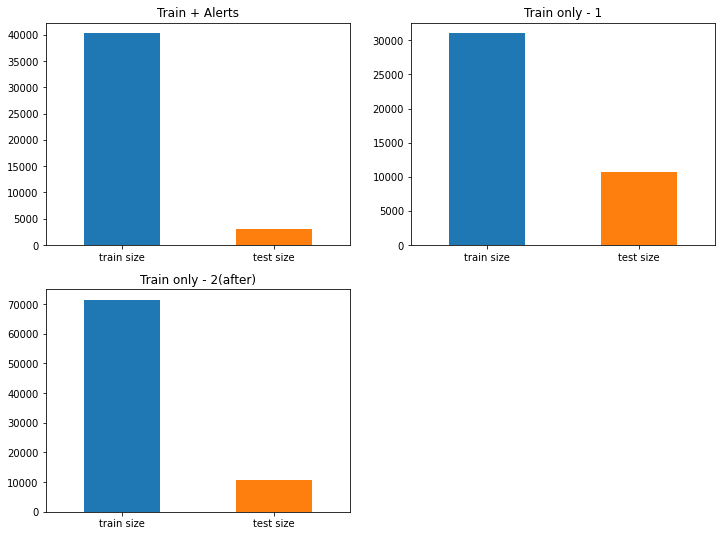

In [ ]:
fig = plt.figure(figsize=(12,9))
namaa = ['Train data', 'Test data']
for i, (name, row) in enumerate(awo_df.iterrows()):
    ax = plt.subplot(2,2, i+1)
    ax.set_title(row.name)
    #ax.get_xaxis().set_visible(False)
    ax.set_xticklabels(namaa)
    awo_df.iloc[i].plot.bar(color=['C0', 'C1'])
    plt.xticks(rotation=0)

#fig.legend(ax.bar([0,0],[0,0], color=['C0','C1']),['Train data','Test data'], loc=5)
plt.show()

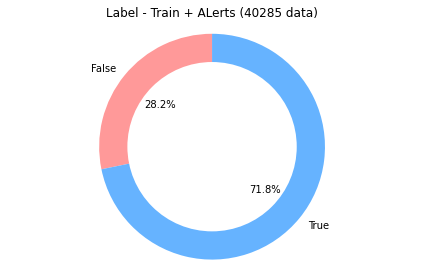

In [ ]:
labels = ['False', 'True']
sizes = [100*(data_trainn_yes1['Labels'].value_counts()[0]/data_trainn_yes1['Labels'].value_counts().sum()), 100*(data_trainn_yes1['Labels'].value_counts()[1]/data_trainn_yes1['Labels'].value_counts().sum())]
colors = ['#ff9999','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Label - Train + ALerts (40285 data)')
centre_circle = plt.Circle((0,0),0.75,fc='White')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

### Data Modelling

#### a) Predict val data (without alerts information) 

In [ ]:
datakita = pd.get_dummies(data=clustered_first, columns=['Cluster'], drop_first=True)
# 80% train and 20% validation data
X1_train, X1_test, y1_train, y1_test = train_test_split(datakita.drop(columns=['Labels']), datakita['Labels'], test_size=0.2, stratify=datakita['Labels'], random_state=42)

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=0)
tree_model.fit(X1_train['hour'].to_frame(), y1_train)
X1_train['waktu_tree']=tree_model.predict_proba(X1_train['hour'].to_frame())[:,1] 
X1_train.drop(columns=['hour'],inplace=True)

X1_test['waktu_tree'] =tree_model.predict_proba(X1_test['hour'].to_frame())[:,1]
X1_test.drop(columns=['hour'],inplace=True)

In [ ]:
X1_train['waktu_tree'].unique()

array([0.70123179, 0.66666667, 0.42245021, 0.63552124, 0.42115459,
       0.3854506 , 0.18581907, 0.34042553])

In [ ]:
smt = SMOTE(random_state=0)
X1_train_SMOTE, y1_train_SMOTE = smt.fit_sample(X1_train, y1_train)

rf = RandomForestClassifier()
xgb = XGBClassifier()
lr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()
svm = SVC()

classifier1 = [rf,xgb,lr,nb,knn,svm]
classifier1nama = ['rf','xgb','lr','nb','knn','svm']

In [ ]:
for i,j in enumerate(classifier1):
  j.fit(X1_train, y1_train)
  y_pred = j.predict(X1_test)
  efwan = f1_score(y1_test,y_pred, average='macro')
  print(f"{classifier1nama[i]}: {efwan}")

rf: 0.513117443436947
xgb: 0.5155942613600771
lr: 0.5323383757265499
nb: 0.5322128432311622
knn: 0.564636699501909
svm: 0.5093653979761992


In [ ]:
for i,j in enumerate(classifier1):
  j.fit(X1_train_SMOTE, y1_train_SMOTE)
  y_pred = j.predict(X1_test.values)
  efwan = f1_score(y1_test,y_pred, average='macro')
  print(f"{classifier1nama[i]}: {efwan}")

rf: 0.5705035509663986
xgb: 0.5734621793234234
lr: 0.5673415802327819
nb: 0.5337331304998119
knn: 0.5617485841776972
svm: 0.5616417657866745


In [ ]:
param_test = {'max_depth':[7,9,11], 'min_samples_split':[7,9,11]}
gsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=7), param_grid = param_test, scoring='f1_macro',n_jobs=-1, cv=5)
gsearch.fit(X1_train_SMOTE, y1_train_SMOTE)
gsearch.cv_results_['mean_test_score'], gsearch.cv_results_['params'], gsearch.best_params_, gsearch.best_score_

(array([0.54946843, 0.54946843, 0.54987715, 0.54926961, 0.54926961,
        0.54926961, 0.54926961, 0.54926961, 0.54926961]),
 [{'max_depth': 7, 'min_samples_split': 7},
  {'max_depth': 7, 'min_samples_split': 9},
  {'max_depth': 7, 'min_samples_split': 11},
  {'max_depth': 9, 'min_samples_split': 7},
  {'max_depth': 9, 'min_samples_split': 9},
  {'max_depth': 9, 'min_samples_split': 11},
  {'max_depth': 11, 'min_samples_split': 7},
  {'max_depth': 11, 'min_samples_split': 9},
  {'max_depth': 11, 'min_samples_split': 11}],
 {'max_depth': 7, 'min_samples_split': 11},
 0.5498771487678958)

In [ ]:
param_test2r = {'min_samples_leaf':[7,9,11,13]}
gsearch2r = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100,max_depth= 9, min_samples_split= 11, class_weight='balanced', random_state=7), param_grid = param_test2r, scoring='f1_macro',n_jobs=-1, cv=5)
gsearch2r.fit(X1_train_SMOTE, y1_train_SMOTE)
gsearch2r.cv_results_['mean_test_score'], gsearch2r.cv_results_['params'], gsearch2r.best_params_, gsearch2r.best_score_

(array([0.54931383, 0.5494912 , 0.54946152, 0.54946152]),
 [{'min_samples_leaf': 7},
  {'min_samples_leaf': 9},
  {'min_samples_leaf': 11},
  {'min_samples_leaf': 13}],
 {'min_samples_leaf': 9},
 0.5494912007884507)

In [ ]:
rf1 = RandomForestClassifier(min_samples_split=5, max_depth=9, n_estimators=100,min_samples_leaf= 11 , class_weight='balanced', random_state=7)

In [ ]:
rf1.fit(X1_train_SMOTE, y1_train_SMOTE)
y_pred = rf1.predict(X1_test.values)
print('rf tuned :', f1_score(y1_test,y_pred, average='macro'))

rf tuned : 0.5705035509663986


#### b) Predict val data (with alerts information)

In [ ]:
# cardinal direction

def mag(x):
    if 0<=x<89:
        return 'North'
    elif 89<=x<179:
        return 'East'
    elif 179<=x<269:
        return 'South'
    elif 269<=x<361:
        return 'West'

In [ ]:
s1 = s1.drop(columns=['index','lat','long'])
s1['magvar'] = s1['magvar'].apply(lambda x : mag(x))
s1 = pd.get_dummies(data=s1, columns=['Cluster','magvar','type'], drop_first=True)

In [ ]:
# 80% train and 20% validation data
X2_train, X2_test, y2_train, y2_test = train_test_split(s1.drop(columns=['Labels']), s1['Labels'], test_size=0.2, stratify=s1['Labels'], random_state=42)

In [ ]:
tree_models = DecisionTreeClassifier(max_depth=3, random_state=0)
tree_models.fit(X2_train['hour_y'].to_frame(), y2_train)
X2_train['waktu_tree']=tree_models.predict_proba(X2_train['hour_y'].to_frame())[:,1] 
X2_train.drop(columns=['hour_y'],inplace=True)

X2_test['waktu_tree'] =tree_models.predict_proba(X2_test['hour_y'].to_frame())[:,1]
X2_test.drop(columns=['hour_y'],inplace=True)

In [ ]:
smt1 = SMOTE(random_state=0)
X2_train_SMOTE, y2_train_SMOTE = smt1.fit_sample(X2_train, y2_train)

In [ ]:
for i,j in enumerate(classifier1):
  j.fit(X2_train_SMOTE, y2_train_SMOTE)
  y_pred = j.predict(X2_test.values)
  efwan = f1_score(y2_test,y_pred, average='macro')
  print(f"{classifier1nama[i]}: {efwan}")

rf: 0.7443751890097512
xgb: 0.7686983823122631
lr: 0.7610582399243434
nb: 0.7567064805192438
knn: 0.7250405828020137
svm: 0.767606560829845


In [ ]:
for i,j in enumerate(classifier1):
  j.fit(X2_train, y2_train)
  y_pred = j.predict(X2_test)
  efwan = f1_score(y2_test,y_pred, average='macro')
  print(f"{classifier1nama[i]}: {efwan}")

rf: 0.7592046697432395
xgb: 0.7674338226254867
lr: 0.7670416263512416
nb: 0.7571682464077849
knn: 0.7389464835624681
svm: 0.767606560829845


In [ ]:
param_test = {'max_depth':[2,3,5,7,8,9], 'min_samples_split':[3,5,7,9,11]}
gsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=7), param_grid = param_test, scoring='f1_macro',n_jobs=-1, cv=5)
gsearch.fit(X2_train, y2_train)
gsearch.cv_results_['mean_test_score'], gsearch.cv_results_['params'], gsearch.best_params_, gsearch.best_score_

(array([0.76245331, 0.76245331, 0.76245331, 0.76245331, 0.76245331,
        0.76254613, 0.76254613, 0.76254613, 0.76254613, 0.76254613,
        0.76257054, 0.76257054, 0.76260398, 0.76260398, 0.76260398,
        0.76349492, 0.76393782, 0.76365383, 0.76317823, 0.76430652,
        0.76466207, 0.76449417, 0.76495088, 0.76496812, 0.76394621,
        0.76454311, 0.76488354, 0.76502749, 0.7652528 , 0.76498044]),
 [{'max_depth': 2, 'min_samples_split': 3},
  {'max_depth': 2, 'min_samples_split': 5},
  {'max_depth': 2, 'min_samples_split': 7},
  {'max_depth': 2, 'min_samples_split': 9},
  {'max_depth': 2, 'min_samples_split': 11},
  {'max_depth': 3, 'min_samples_split': 3},
  {'max_depth': 3, 'min_samples_split': 5},
  {'max_depth': 3, 'min_samples_split': 7},
  {'max_depth': 3, 'min_samples_split': 9},
  {'max_depth': 3, 'min_samples_split': 11},
  {'max_depth': 5, 'min_samples_split': 3},
  {'max_depth': 5, 'min_samples_split': 5},
  {'max_depth': 5, 'min_samples_split': 7},
  {'max_depth': 

In [ ]:
param_test2r = {'min_samples_leaf':[7,9,11,13]}
gsearch2r = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100,max_depth= 9, min_samples_split= 9, class_weight='balanced', random_state=7), param_grid = param_test2r, scoring='f1_macro',n_jobs=-1, cv=5)
gsearch2r.fit(X2_train, y2_train)
gsearch2r.cv_results_['mean_test_score'], gsearch2r.cv_results_['params'], gsearch2r.best_params_, gsearch2r.best_score_

(array([0.76515109, 0.76474921, 0.76524957, 0.76487808]),
 [{'min_samples_leaf': 7},
  {'min_samples_leaf': 9},
  {'min_samples_leaf': 11},
  {'min_samples_leaf': 13}],
 {'min_samples_leaf': 11},
 0.765249566309137)

In [ ]:
rf2 = RandomForestClassifier(min_samples_split=9, max_depth=9, n_estimators=100,min_samples_leaf= 11 , class_weight='balanced', random_state=7)

In [ ]:
rf2.fit(X2_train, y2_train)
y_pred = rf2.predict(X2_test)
print('rf tuned :', f1_score(y2_test,y_pred, average='macro'))

rf tuned : 0.7680263500415095


### Predict Test data

#### a) Predict test data (without alerts information)

In [ ]:
data_testt_non1 = data_testt_non1.drop(columns=['index','s2','day_week','lat','long','lookup1'])
data_testt_non1 = pd.get_dummies(data=data_testt_non1, columns=['Cluster'], drop_first=True)
data_testt_non1['waktu_tree'] = tree_model.predict_proba(data_testt_non1['hour'].to_frame())[:,1]
data_testt_non1.drop(columns=['hour'],inplace=True)

In [ ]:
rf1.fit(X1_train_SMOTE, y1_train_SMOTE)
s2non_uji = rf1.predict(data_testt_non1)
s2non_uji = pd.DataFrame(s2non_uji,columns=['Labels'],index=data_testt_non1.index)
s2non_uji['Labels'] = s2non_uji['Labels'].map({1:'True',0:'False'})

In [ ]:
s2non_uji.head()

,Labels
0,True
2,False
3,True
4,False
5,True


#### b) Predict test data (with alerts information)

In [ ]:
s2 = s2.drop(columns=['index','lat','long'])
s2['magvar'] = s2['magvar'].apply(lambda x : mag(x))
s2 = pd.get_dummies(data=s2, columns=['Cluster','magvar','type'], drop_first=True)
s2['waktu_tree'] = tree_models.predict_proba(s2['hour_y'].to_frame())[:,1]
s2.drop(columns=['hour_y'],inplace=True)

In [ ]:
rf1.fit(X2_train_SMOTE, y2_train_SMOTE)
y_uji = rf1.predict(s2)
s2_uji = pd.DataFrame(y_uji,columns=['Labels'],index=s2.index)
s2_uji['Labels'] = s2_uji['Labels'].map({1:'True',0:'False'})

In [ ]:
s2_uji.head()

,Labels
1,True
7,True
8,True
18,True
38,True


#### c) Combine :)

In [ ]:
aye = s2_uji.combine_first(s2non_uji)
ids = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dsw/data_test.csv')
aye['Ids'] = ids['Ids']
aye = aye.reindex(columns=['Ids','Labels'])

In [ ]:
aye['Labels'].value_counts()

True     9419
False    4422
Name: Labels, dtype: int64

In [ ]:
#aye.to_csv('thankyou.csv', index=False)